In [1]:
import numpy as np
temp_list = np.array(range(10))
print(temp_list)
print(temp_list / 10) # 표준화, 즉 모든 값의 범위가 0~1 사이의 값으로 변환됨

[0 1 2 3 4 5 6 7 8 9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [2]:
# 일종의 파라미터 튜닝 --> 최적화된 값을 찾기 위한 과정

In [3]:
from tensorflow import keras
(x,y),(xt,yt) = keras.datasets.fashion_mnist.load_data() # (xt,yt) --> 최종 검증하기 위한 데이터세트
x.shape, y.shape, xt.shape, yt.shape # 3차원 배열

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

### 정규화 (StandardScale OR 표준 점수)

In [4]:
# 둘 중 뭘 사용해도 상관 없음
# 범위를 모르는 경우 유용
# - StandardScaler의 경우 (2차원 배열로 변환해 주어야 함)

x_2d = x.reshape(-1,28*28) # 개수는 알아서 맞추어 줌
# 차수를 바꿔주지 않으면 ValueError 발생
# (dim 3, expected <= 2. --> 2차원을 기대하나, 3차원을 이용하여 에러가 났다는 의미)

# 아래 방법이 원조 방법
#    x_2d = x.reshape(60000, 28,28)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_scaled = ss.fit_transform(x_2d)
x_scaled.shape

# TypeError...not collable --> 함수가 아니므로 호출할 수 없다는 의미로 괄호를 빼 주어야 함

(60000, 784)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_target, y_train, y_target = train_test_split(x_scaled, y)
x_train.shape, x_target.shape, y_train.shape, y_target.shape

((45000, 784), (15000, 784), (45000,), (15000,))

In [6]:
# 범위를 아는 경우 표준점수가 편함
# - 표준점수
# x_scaled = x / 255.0

# 이미지 데이터이기 때문에 하나의 이미지가 픽셀로 되어 있고 각각의 픽셀은 RGB 색상값 중 하나로 이루어져 있기 때문에
# 255로 나누어 준 것


# 단 이 경우에도 데이터를 따로 2차원 배열로 변환해 주어야 함 (input_shape 매개변수 이용)

In [7]:
def make_model(layer = None):
# 추가할 층이 없으면 기본 형태로 만듦
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28*28,))) # StandardScaler로 이미 펼쳐주었기 때문에 형식만 맞춰준 것이고,
                                                          # 표준점수로 한 경우에는 (28, 28)로 데이터를 펴 주어야 함 (784로 표현해도 상관 무)
                                                          # 참고로 튜플에서의 1차원 표현은 (n,) <-- 이렇게 표현해 주어야 함
        
    model.add(keras.layers.Dense(100, activation='relu')) # sigmoid 보다 성능 좋음
    if layer:
        model.add(layer)
              
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

# 이 함수를 통해 원하는 대로 층을 구성해보기
#       기존의 층 1개가 있고, 또 다른 층이 있다면 추가해주기

## - 기본적인 모델 만들어보기

In [8]:
model = make_model() # 지금부터는 colab 해도 됨
model.summary()

# dense_1 : 785 * 100 + 100    # 785개를 가지고 100번 학습하도록 돌린 것
# dense_2 : 100 * 10 + 100     # 100개를 가지고 다시 10번 학습하도록 돌린 것

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 784),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'flatten_input'}},
  {'class_name': 'Flatten',
   'config': {'name': 'flatten',
    'trainable': True,
    'batch_input_shape': (None, 784),
    'dtype': 'float32',
    'data_format': 'channels_last'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 100,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 10,
   

In [10]:
# compile : 작성한 코드들을 컴퓨터가 이해할 수 있는 이진법(0,1)으로 번역해주는 기능으로, 진짜 신경망처럼 작업할 수 있도록 만들어 줌 

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # metrics = [] 배열 형식 준 것
history = model.fit(x_train, y_train, epochs=5, verbose=0) # 'verbose=0' : 일일이 에포크 마다 보고하지 않고 실행만 됨 (Dafault : 1)

# .history로 결과값을 확인하면 되기 때문에 에포크값을 크게 줄 경우에는 0을 지정해 줌

In [11]:
history.history # fit 결과값을 넣은 변수는 객체이기 때문에 출력은 불가능 .history로 결과를 확인해야 함

{'loss': [0.467506468296051,
  0.3445262610912323,
  0.30566728115081787,
  0.2777573764324188,
  0.2578951418399811],
 'accuracy': [0.8344888687133789,
  0.874311089515686,
  0.8871777653694153,
  0.8975777626037598,
  0.9045777916908264]}

In [12]:
# loss값만 확인하기
history.history['loss']

[0.467506468296051,
 0.3445262610912323,
 0.30566728115081787,
 0.2777573764324188,
 0.2578951418399811]

In [13]:
# 키값만 출력
history.history.keys()

# 지금까지 데이터 구조 살펴봄

dict_keys(['loss', 'accuracy'])

## 위 모델 시각화

In [14]:
import matplotlib.pyplot as plt

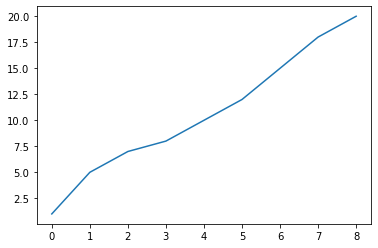

In [15]:
temp_list =[1,5,7,8,10,12,15,18,20] 
plt.plot(temp_list)
plt.show()

# x축값은 자동생성 --> 횟수

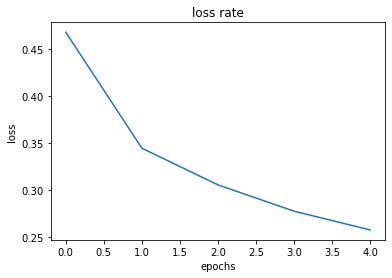

In [16]:
temp_list = history.history['loss'] # 에포크값 그대로 적용된 것
plt.plot(temp_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss rate')
plt.show()

# 학습할수록(에포크 진행 시마다) --> 정확도 up, 손실율 down

### epochs 값 늘리면? 5 --> 25

In [17]:
model = make_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=25, verbose=0)

### 이번에는 손실 방향 X --> 향상되는 방향으로 살펴보기

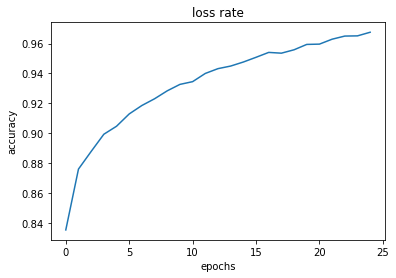

In [18]:
# 정확도
temp_list = history.history['accuracy']
plt.plot(temp_list)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('loss rate')
plt.show()
# 분할해서 각각 하나씩 그려보기

## 검증세트로 그려보기

In [19]:
# 이전까지 학습데이터를 기반으로 한 손실율과 정확성을 살펴봄
# 과적합을 판단하기 위해서는 훈련세트 뿐만 아니라 타깃에 대한 검증세트에 대한 데이터를 살펴봐야 함
# --> 검증세트도 에포크값 할당
model = make_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 검증세트는 fit 적용이 달라짐
history = model.fit(x_train, y_train, epochs=25, verbose=0, validation_data=(x_target, y_target))
# keras에서는 sklearn과 달리 훈련세트와 검증세트를 따로 학습하는 것이 아니라 한번에 학습함

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

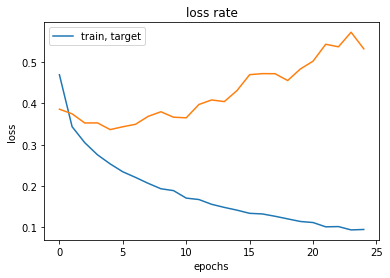

In [21]:
# 훈련세트와 검증세트의 손실값만 살펴보기

train_loss = history.history['loss']
target_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(target_loss)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train, target'])
plt.title('loss rate')
plt.show()

### 전형적인 과소적합의 형태를 띄고 있음 (훈련 < 검증)
### 과적합이 나오는 이유...특정 가중치가 과하게 적용된 것

---------------

### 선형 회귀 모델을 이용할 때 과적합을 해결하기 위해 규제 알고리즘(릿지, 라쏘)을 사용했듯,
### keras에도 이와 같은 알고리즘이 있음
### - *하이퍼 파라미터는 성능이 가장 좋은 adam을 써 줌으로써 이미 적용된 셈*

----------------

## < keras에서 과적합 해결하기 >
### 학습에 참여하는 784개의 모든 데이터를 사용하는 것이 아니라 랜덤으로 데이터를 빼주어 결과값을 출력해보기
### - 일부 출력층, 즉 뉴런의 출력을 무작위로 꺼내어...0으로 만들어버림 (단, 전체적인 구조는 변경하지 않음)
### - 특정 뉴런에 과하게 의존하는 것을 막아줌
## >> Drop-out

In [22]:
model = make_model(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [23]:
model = make_model(keras.layers.Dropout(0.3)) # summary로 확인하고 난 후 다시 compile로 적용하려면 모델을 다시 만들어 주어야 함
                                              # complie을 해 주면 모델의 성능을 다시 측정,
                                              # 그러나 compile을 안하고 fit만 해주면 훈련 횟수가 누적돼버림
        
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=25, verbose=0, validation_data=(x_target, y_target))

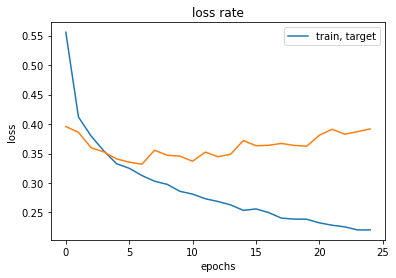

In [24]:
# 훈련세트와 검증세트의 손실값만 살펴보기

train_loss = history.history['loss']
target_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(target_loss)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train, target'])
plt.title('loss rate')
plt.show()

In [25]:
# 에포크값이 너무 딱 떨어지는 것 보다는 살짝 괴리가 있는 것이 보다 적합할 수도...
# 위에서 찾은 하이퍼 파라미터값(epochs : 10)으로 다시 훈련하기

In [26]:
model = make_model(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=7, verbose=0, validation_data=(x_target, y_target))

In [27]:
# 검증 --> evaluation...사용해보기
model.evaluate(x_target, y_target)

469/469 [==============================] - 2s 3ms/step - loss: 0.3438 - accuracy: 0.8796


[0.3437618017196655, 0.8795999884605408]

# 모델을 파일로 저장하기

In [28]:
# 인공지능 모델은 주로 확장자, h5로 저장
# - 모델의 파라미터 저장...하이퍼 파라미터(weights)
model.save_weights('model-weight.h5')
# 파라미터 적용하여 모델 구성해보기

In [29]:
# 두번째 방법
# - 모델 구조와 파라미터를 함께 저장
model.save('model-whoile.h5')

## 1. 모델 객체 생성...Sequencial
## 2. 레이어 구성...model(keras, layer, Dense) or Dropout
## 3. 모델 compile
## 4. 모델 적용 model.fit...(훈련세트) or 검증세트

-------------------

### 저장한 파라미터 불러올 때 주의할 점
### - 모델 만들 때 저장된 파라미터를 불러올 수 있는데 이때 이전에 저장했던 모델과 정확히 동일해야 함

In [30]:
model = make_model(keras.layers.Dropout(0.3))
model.load_weights('model-weight.h5')

# 파라미터 적용하여 모델 구성
# 이전에 저장한 파라미터(가중치)값을 compile 해 주어야 함 (단, fit은 X)
model.compile(optimizer="adam", loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.evaluate(x_target, y_target)

469/469 [==============================] - 2s 3ms/step - loss: 0.3438 - accuracy: 0.8796


[0.3437618017196655, 0.8795999884605408]

### 저장된 파일 불러오기

In [31]:
model = keras.models.load_model('model-whoile.h5')
model.evaluate(x_target, y_target) # loss, accuracy 출력

# 'model-weight.h5'는 파라미터만 저장돼 있는 것이고,
# 'model-whoile.h5'는 파라미터 뿐만 아니라 모델 전체를 저장한 파일을
# 불러온 것이므로 바로 사용 가능

469/469 [==============================] - 2s 2ms/step - loss: 0.3438 - accuracy: 0.8796


[0.3437618017196655, 0.8795999884605408]

#### ** 정확하게 가져온 것을 알 수 있음

-----------------------

# < 콜백, 조기종료 >
### - 호출을 받아 실행 중에 최적의 값을 만나게 되면 즉시 종료
### - fit() 메서드의 callbacks 매개변수에 리스트로 전달
### - Modelcheckpoint 콜백...지정된 에포크 횟수 동안 최상의 검증 점수를 만드는 모델을 저장

In [32]:
# ModelCheckpoint 기본적으로 최상의 검증 점수를 만들어 h5로 저장한 후, 조기종료

model = make_model(keras.layers.Dropout(0.3)) # 주로 과적합을 막기 위해 0.3을 줌
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])
# 다중분류이므로 --> loss = 'sparse_categorical_crossentropy'

checkpoint= keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
# 지금까지 keras로 make_model에 디자인 층을 생성하고 compile까지 한 모델에
# 모델체크포인트라는 속성을 추가해 줌으로써
# --> 최상의 조건이 되었을 때, 'best-model.h5'라고 저장
#     이렇게 만들어 준 파일은 객체를 받아 와 fit 메서드에서 써 주어야 함

model.fit(x_train,y_train, epochs=25, validation_data=(x_target,y_target), verbose=1,
         callbacks=[checkpoint])
# 모델에 최종적으로 fit, 학습시킴
# (검증용 데이터를 학습시킬 때는 validation_data 매개변수 사용)
# callbacks=[checkpoint] --> 'best-model.h5' 속성까지 실행됨

Epoch 1/25
1407/1407 [==============================] - 8s 5ms/step - loss: 0.5477 - accuracy: 0.8082 - val_loss: 0.3975 - val_accuracy: 0.8557
Epoch 2/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.4117 - accuracy: 0.8533 - val_loss: 0.3624 - val_accuracy: 0.8657
Epoch 3/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3736 - accuracy: 0.8650 - val_loss: 0.3545 - val_accuracy: 0.8692
Epoch 4/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3509 - accuracy: 0.8728 - val_loss: 0.3467 - val_accuracy: 0.8742
Epoch 5/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3375 - accuracy: 0.8763 - val_loss: 0.3555 - val_accuracy: 0.8722
Epoch 6/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3235 - accuracy: 0.8799 - val_loss: 0.3415 - val_accuracy: 0.8774
Epoch 7/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3112 - accuracy: 0.8864 - val_loss: 0.3439 - val_accuracy:

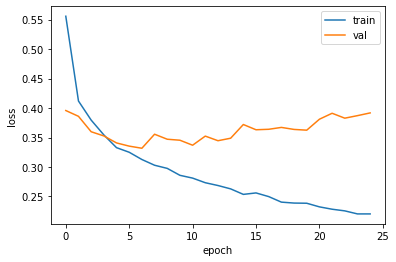

In [33]:
plt.plot(history.history['loss']) # 훈련세트의 손실값
plt.plot(history.history['val_loss']) # 검증세트의 손실값
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [34]:
# 아직 조기종료는 해 주지 않은 상태

# 조기종료..모델이 과적합이 될 것 같으면 종료...일종의 규제방법 중 하나
# keras에 조기종료해 주는 콜백이 존재함...early_stopping.stopped_epoch
# EarlyStopping + ModelCheckpoint <-- 함께 사용하면 가장 낮은 검증손실의 모델을 파일에 저장하고 
# 검즘손실이 다시 상승할 때 훈련 중지, 현재 모델의 파라미터를 최상의 파라미터로 전환

model = make_model(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

checkpoint= keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=2)
# patience=2 --> 지정해 주지 않으면 1이 반환됨
# 상승한 지점을 1개만 보는 것이 아니라 2번까지는 살펴보겠다는 것

history =  model.fit(x_train,y_train, epochs=25, validation_data=(x_target,y_target), verbose=1,
         callbacks=[checkpoint, early_stopping])

# 에포크값이 커지면(검증 점수가 너무 커지면) 규제를 적용해도 과대적합이 커지는 경향이 있었음

Epoch 1/25
1407/1407 [==============================] - 7s 4ms/step - loss: 0.5487 - accuracy: 0.8111 - val_loss: 0.4013 - val_accuracy: 0.8591
Epoch 2/25
1407/1407 [==============================] - 7s 5ms/step - loss: 0.4132 - accuracy: 0.8530 - val_loss: 0.3657 - val_accuracy: 0.8675
Epoch 3/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3756 - accuracy: 0.8643 - val_loss: 0.3594 - val_accuracy: 0.8673
Epoch 4/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3566 - accuracy: 0.8705 - val_loss: 0.3608 - val_accuracy: 0.8722
Epoch 5/25
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3389 - accuracy: 0.8758 - val_loss: 0.3579 - val_accuracy: 0.8696
Epoch 6/25
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3270 - accuracy: 0.8781 - val_loss: 0.3457 - val_accuracy: 0.8780
Epoch 7/25
1407/1407 [==============================] - 9s 6ms/step - loss: 0.3147 - accuracy: 0.8837 - val_loss: 0.3468 - val_accuracy:

In [35]:
# 몇 번째의 에포크에서 훈련이 중지되었는지, 조기종료값 반환
# 최적의 파라미터값이 6인 것을 예측할 수 있음

early_stopping.stopped_epoch

7

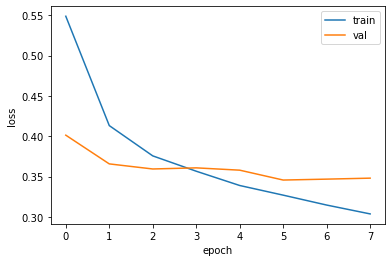

In [36]:
plt.plot(history.history['loss']) # 훈련세트의 손실값
plt.plot(history.history['val_loss']) # 검증세트의 손실값
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [37]:
model.evaluate(x_target,y_target)

469/469 [==============================] - 2s 3ms/step - loss: 0.3457 - accuracy: 0.8780


[0.34569042921066284, 0.878000020980835]